# Figures for Active Keyword Selection Paper
Here, we use the output json files produced while running the experiments to plot the graphs presented in the paper.

In [12]:
%load_ext nb_black

import json
from datetime import timedelta
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
import numpy as np
from tqdm.notebook import tqdm
from matplotlib_venn import venn3, venn3_circles

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [462]:
mpl.style.use("default")
font_size = 20
font = {"family": "normal", "size": font_size}
mpl.rc("font", **font)

<IPython.core.display.Javascript object>

In [554]:
file_types = ["pdf"]

# results_filepath, graph_type = "../../results_tweet_graph.json", "tweet"
# uncomment below if experiments were run using the user-hashtag graph
results_filepath, graph_type = "../../results_user_graph.json", "user"
runtime_results_filepath = "runtime_recorder.json"
figure_root_dir = Path(f"figures/pdf/{graph_type}/")
if not figure_root_dir.is_dir():
    figure_root_dir.mkdir(parents=True)

<IPython.core.display.Javascript object>

Note you need to run the `experiments/main.py` file in order to generate the `results.json` and `runtime_recorder.json` files. Copies of the results reported in the paper were pre-added to the `experiments` folder.

In [555]:
with open(results_filepath, "r") as f:
    results = json.load(f)

with open(runtime_results_filepath, "r") as f:
    runtimes = json.load(f)

<IPython.core.display.Javascript object>

In [556]:
# transform from shortnames used in file to plot names for each method & baseline
method_map = {
    "ours": "KeySelect",
    "degree": "Degree Centrality",
    "random": "Random Walk",
    "tfidf": "Tf-Idf",
    "word2vec": "Word2vec",
}
budgets, topics = [30, 10, 3], ["VACCINE", "MASK", "LOCKDOWN"]
seed_keyword_set_size = 10
other_methods = ["degree", "random", "tfidf", "word2vec"]

<IPython.core.display.Javascript object>

In [526]:
def get_measure_vals(topic, budget, measure, fn=None):
    measure_vals = {}

    for day in results:
        for method in (
            results.get(day).get(topic).get(str(seed_keyword_set_size)).get(str(budget))
        ):
            if method not in measure_vals:
                measure_vals[method] = []

            if fn:
                val = fn(
                    results.get(day)
                    .get(topic)
                    .get(str(seed_keyword_set_size))
                    .get(str(budget))
                    .get(method)
                    .get(measure)
                )
            else:
                val = (
                    results.get(day)
                    .get(topic)
                    .get(str(seed_keyword_set_size))
                    .get(str(budget))
                    .get(method)
                    .get(measure)
                )
            measure_vals[method].append(val)

    return (
        [method_map[method] for method in measure_vals],
        [measure_vals[method] for method in measure_vals],
    )

<IPython.core.display.Javascript object>

In [527]:
def get_temporal_figure(measure, fn=None):
    fig, axs = plt.subplots(len(budgets), len(topics), sharex=True, figsize=(14, 8))
    day_array = list(range(1, 31))

    plot_list = []
    for topic_idx, topic in enumerate(topics):
        for budget_idx, budget in enumerate(budgets):
            methods, recall_arrays = get_measure_vals(topic, budget, measure, fn=fn)
            for method, recall_array in zip(methods, recall_arrays):
                (line,) = axs[budget_idx, topic_idx].plot(
                    day_array, recall_array, linewidth=1, label=method
                )
                plot_list.append(line)
            if budget_idx == 0:
                axs[budget_idx, topic_idx].set_title(f"{topic}")
            if topic_idx == 0:
                axs[budget_idx, topic_idx].set_ylabel(f"{measure}")
            axs[budget_idx, topic_idx].set_xlim([1, 30])
            axs[budget_idx, topic_idx].spines["top"].set_visible(False)
            axs[budget_idx, topic_idx].spines["right"].set_visible(False)

    fig.tight_layout(pad=2.0)
    # fig.supxlabel(f"Day of the month of April 2020 using {graph_type}-hashtag graphs")

    plot_subset = plot_list[0 : len(methods)]
    lgd = fig.legend(
        handles=plot_subset,
        labels=methods,
        bbox_to_anchor=(0.02, 1.0, 1.0, 0.102),
        loc=3,
        #  mode="expand",
        borderaxespad=0.0,
        ncol=len(methods),
        fontsize=font_size,
        fancybox=True,
        shadow=False,
        frameon=True,
    )

    for file_type in file_types:
        figure_filepath = figure_root_dir.joinpath(f"{measure}.{file_type}")
        plt.savefig(figure_filepath, dpi=300, bbox_inches="tight")

    plt.show()

<IPython.core.display.Javascript object>

In [528]:
from sklearn.preprocessing import normalize


def get_relative_vals(topic, method, measure, fn=None):
    val_arrays = []
    baseline_arrays = []

    for method in other_methods:
        baseline_arrays.append(
            normalize(
                np.array(
                    [
                        results.get(day)
                        .get(topic)
                        .get(str(seed_keyword_set_size))
                        .get(str(budget))
                        .get("ours")
                        .get(measure)
                        for day in results
                    ]
                ).reshape(1, -1)
            )
        )
        val_arrays.append(
            normalize(
                np.array(
                    [
                        results.get(day)
                        .get(topic)
                        .get(str(seed_keyword_set_size))
                        .get(str(budget))
                        .get(method)
                        .get(measure)
                        for day in results
                    ]
                ).reshape(1, -1)
            )
        )

    return (
        [method_map[method] for method in other_methods],
        baseline_arrays,
        val_arrays,
    )

<IPython.core.display.Javascript object>

In [529]:
def get_pairwise_relative_figure(measure, fn=None):
    fig, axs = plt.subplots(len(budgets), len(topics), figsize=(12, 16))
    plot_line = []
    for topic_idx, topic in enumerate(topics):
        for budget_idx, budget in enumerate(budgets):
            methods, baseline_arrays, val_arrays = get_relative_vals(
                topic, budget, measure, fn=fn
            )
            for method, baseline_array, val_array in zip(
                methods, baseline_arrays, recall_arrays
            ):
                (line,) = axs[budget_idx, topic_idx].plot(
                    baseline_array, val_array, linewidth=1, label=method
                )
                plot_line.append(line)
            if budget_idx == 0:
                axs[budget_idx, topic_idx].set_title(f"{topic}")
            if topic_idx == 0:
                axs[budget_idx, topic_idx].set_ylabel(f"{measure}")
            # need to normalize both the x & y axis
            axs[budget_idx, topic_idx].set_xlim([0, 1])
            axs[budget_idx, topic_idx].set_ylim([0, 1])
            axs[budget_idx, topic_idx].spines["top"].set_visible(False)
            axs[budget_idx, topic_idx].spines["right"].set_visible(False)

    fig.tight_layout(pad=2.0)
    # fig.supxlabel(f"KeySelect")
    plot_subset = plot_list[0 : len(methods)]
    lgd = fig.legend(
        handles=plot_subset,
        labels=methods,
        bbox_to_anchor=(0.12, 1.0, 1.0, 0.102),
        loc=3,
        #  mode="expand",
        borderaxespad=0.0,
        ncol=len(methods),
        fontsize=font_size,
        fancybox=True,
        shadow=False,
        frameon=True,
    )

    for file_type in file_types:
        figure_filepath = figure_root_dir.joinpath(f"{measure}.{file_type}")
        plt.savefig(figure_filepath, dpi=300, bbox_inches="tight")

    plt.show()

<IPython.core.display.Javascript object>

In [530]:
def get_pairwise_vals(topic, method, measure, fn=None):
    precision_arrays = []
    our_precision_arrays = []

    for budget in budgets:
        precision_arrays.append(
            normalize(
                np.array(
                    [
                        results.get(day)
                        .get(topic)
                        .get(str(seed_keyword_set_size))
                        .get(str(budget))
                        .get(method)
                        .get(measure)
                        for day in results
                    ]
                ).reshape(1, -1)
            )
        )
        our_precision_arrays.append(
            normalize(
                np.array(
                    [
                        results.get(day)
                        .get(topic)
                        .get(str(seed_keyword_set_size))
                        .get(str(budget))
                        .get("ours")
                        .get(measure)
                        for day in results
                    ]
                ).reshape(1, -1)
            )
        )

    return budgets, our_precision_arrays, precision_arrays

<IPython.core.display.Javascript object>

In [560]:
def get_pairwise_budget_figure(measure, fn=None):
    fig, axs = plt.subplots(len(other_methods), len(topics), figsize=(12, 16))
    day_array = list(range(1, 31))

    plot_list = []
    for topic_idx, topic in enumerate(topics):
        for method_idx, method in enumerate(other_methods):
            budgets, our_precisions, baseline_precisions = get_pairwise_vals(
                topic, method, measure, fn=fn
            )
            for budget, our_precision, baseline_precision in zip(
                budgets, our_precisions, baseline_precisions
            ):
                line = axs[method_idx, topic_idx].scatter(
                    our_precision, baseline_precision, label=budget, s=80, alpha=0.2,
                )
                plot_list.append(line)
            axs[method_idx, topic_idx].plot(
                [0, 1], color="black", linewidth=0.2,
            )
            if method_idx == 0:
                axs[method_idx, topic_idx].set_title(f"{topic}")
            if topic_idx == 0:
                axs[method_idx, topic_idx].set_ylabel(f"{method_map[method]}")
            axs[method_idx, topic_idx].spines["top"].set_visible(False)
            axs[method_idx, topic_idx].spines["right"].set_visible(False)

    fig.tight_layout(pad=2.0)
    fig.supxlabel(f"KeySelect")
    # plt.legend(loc="lower right", title="Budget")
    # for file_type in file_types:
    #    figure_filepath = figure_root_dir.joinpath(f"pairwise_{measure}.{file_type}")
    #    plt.savefig(figure_filepath, dpi=300)
    # plt.show()

    plot_subset = plot_list[0 : len(budgets)]
    lgd = fig.legend(
        handles=plot_subset,
        labels=budgets,
        bbox_to_anchor=(0.02, 1.0, 1.0, 0.102),
        loc=3,
        #  mode="expand",
        borderaxespad=0.0,
        ncol=len(budgets),
        fontsize=font_size,
        fancybox=True,
        shadow=False,
        frameon=True,
    )

    for file_type in file_types:
        figure_filepath = figure_root_dir.joinpath(f"{measure}.{file_type}")
        plt.savefig(figure_filepath, dpi=300, bbox_inches="tight")

    plt.show()

<IPython.core.display.Javascript object>

In [549]:
def get_top_bar_plot(measure):
    fig, axs = plt.subplots(len(budgets), len(topics), sharex=True, figsize=(14, 8))
    day = 30

    plot_list = []
    vals = {method: [] for method in method_map}
    for topic_idx, topic in enumerate(topics):
        for budget_idx, budget in enumerate(budgets):
            for method_idx, method in enumerate(list(method_map)):
                val = (
                    results.get(str(day))
                    .get(topic)
                    .get("10")
                    .get(str(budget))
                    .get(method)
                    .get(measure)
                )
                print(topic, budget, method, val)

                vals[method].append(val)

                (line,) = axs[budget_idx, topic_idx].bar(
                    method_idx, val, label=method_map[method]
                )
                plot_list.append(line)
            if budget_idx == 0:
                axs[budget_idx, topic_idx].set_title(f"{topic}")
            if topic_idx == 0:
                axs[budget_idx, topic_idx].set_ylabel(f"{measure}")
            axs[budget_idx, topic_idx].spines["top"].set_visible(False)
            axs[budget_idx, topic_idx].spines["right"].set_visible(False)

    other_vals = []
    for method in other_methods:
        other_vals.extend(vals[method])
        print(
            f"Max gain across settings between Keyselect, and {method}:",
            np.max(np.array(vals["ours"]) / np.array(vals[method])),
        )

    our_vals = vals["ours"]
    print(
        f"Average performance ratio between other methods and ours: {(sum(our_vals)/len(our_vals))/(sum(other_vals)/len(other_vals))}"
    )

    fig.tight_layout(pad=2.0)
    # fig.supxlabel(f"Retrieval performance using {graph_type}-hashtag graphs")

    plot_subset = plot_list[0 : len(method_map)]
    lgd = fig.legend(
        handles=plot_subset,
        labels=list(method_map.values()),
        bbox_to_anchor=(0.02, 1.0, 1.0, 0.102),
        loc=3,
        #  mode="expand",
        borderaxespad=0.0,
        ncol=len(method_map),
        fontsize=font_size,
        fancybox=True,
        shadow=False,
        frameon=True,
    )

    for file_type in file_types:
        figure_filepath = figure_root_dir.joinpath(f"{measure}_bar.{file_type}")
        plt.savefig(figure_filepath, dpi=300, bbox_inches="tight")

    plt.show()

<IPython.core.display.Javascript object>

## Recall
Code to generate Figure 2.

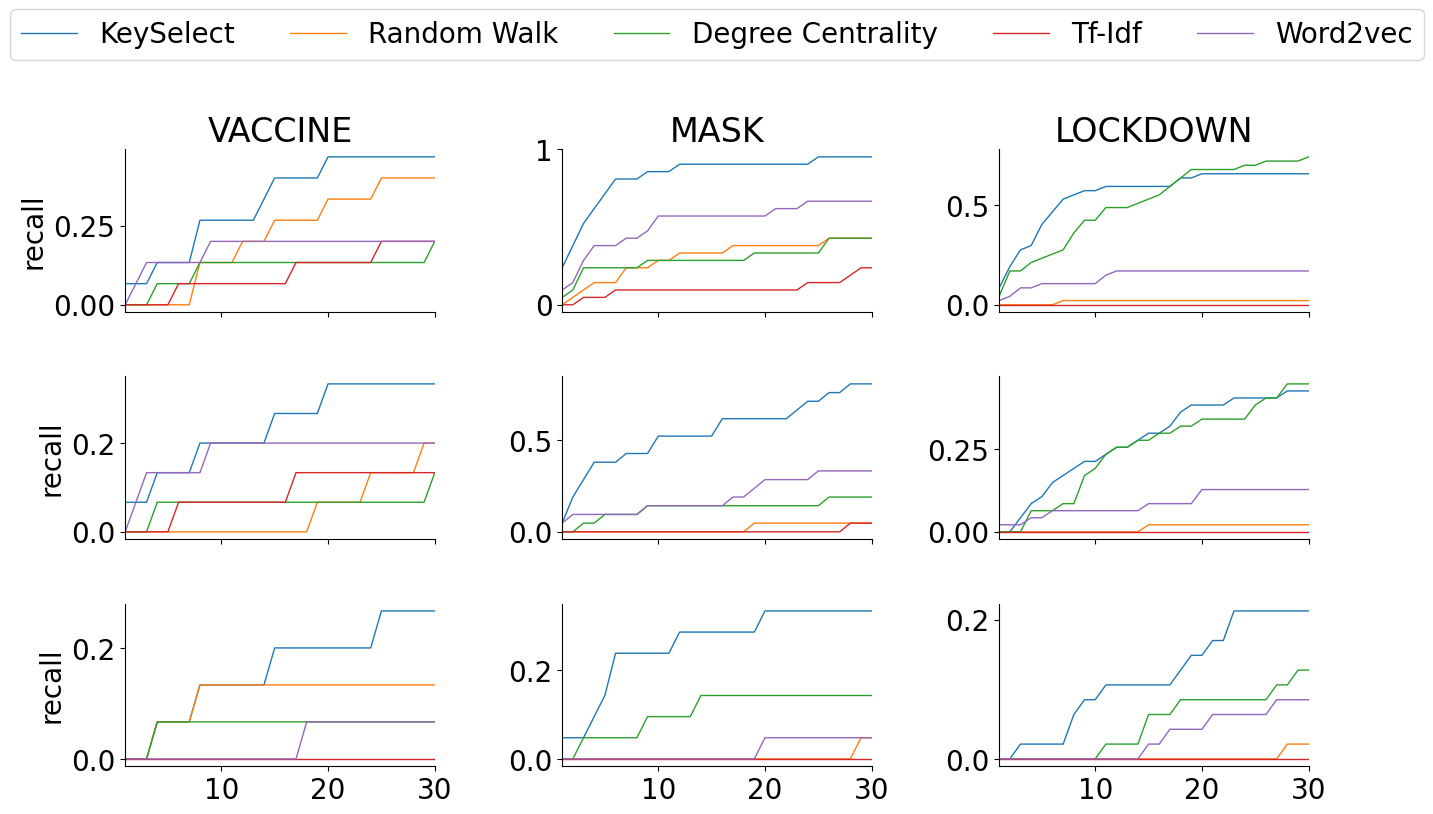

<IPython.core.display.Javascript object>

In [533]:
get_temporal_figure("recall")

Max gain across settings between Keyselect, and degree: 4.25
Max gain across settings between Keyselect, and random: 31.0
Max gain across settings between Keyselect, and tfidf: inf
Max gain across settings between Keyselect, and word2vec: 7.0
Average performance ratio between other methods and ours: 2.8233860363683014


<ipython-input-532-998ac8cc2474>:37: RuntimeWarning: divide by zero encountered in true_divide
  np.max(np.array(vals["ours"]) / np.array(vals[method])),


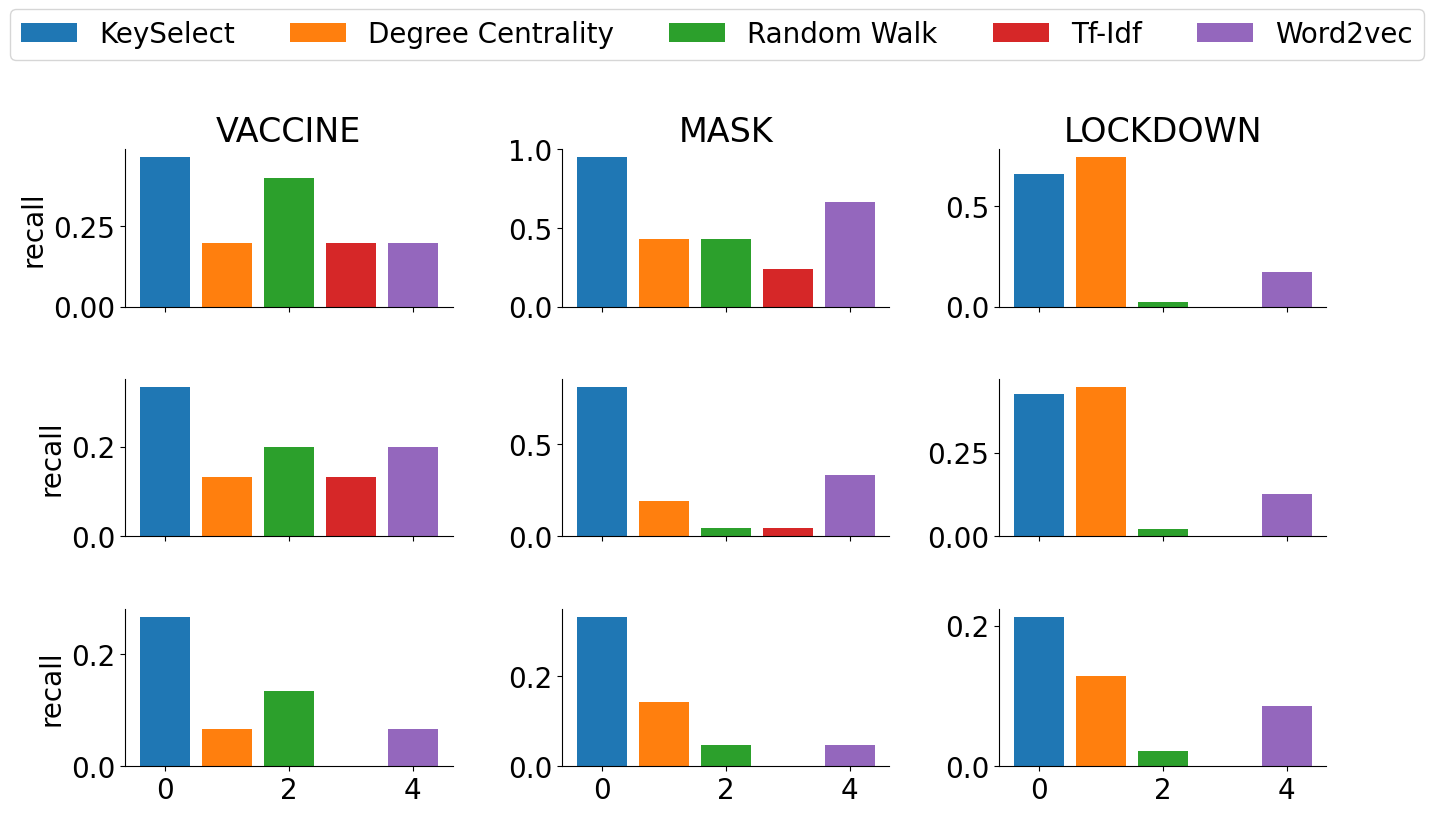

<IPython.core.display.Javascript object>

In [534]:
get_top_bar_plot("recall")

## Precision
Code to generate figure 3.

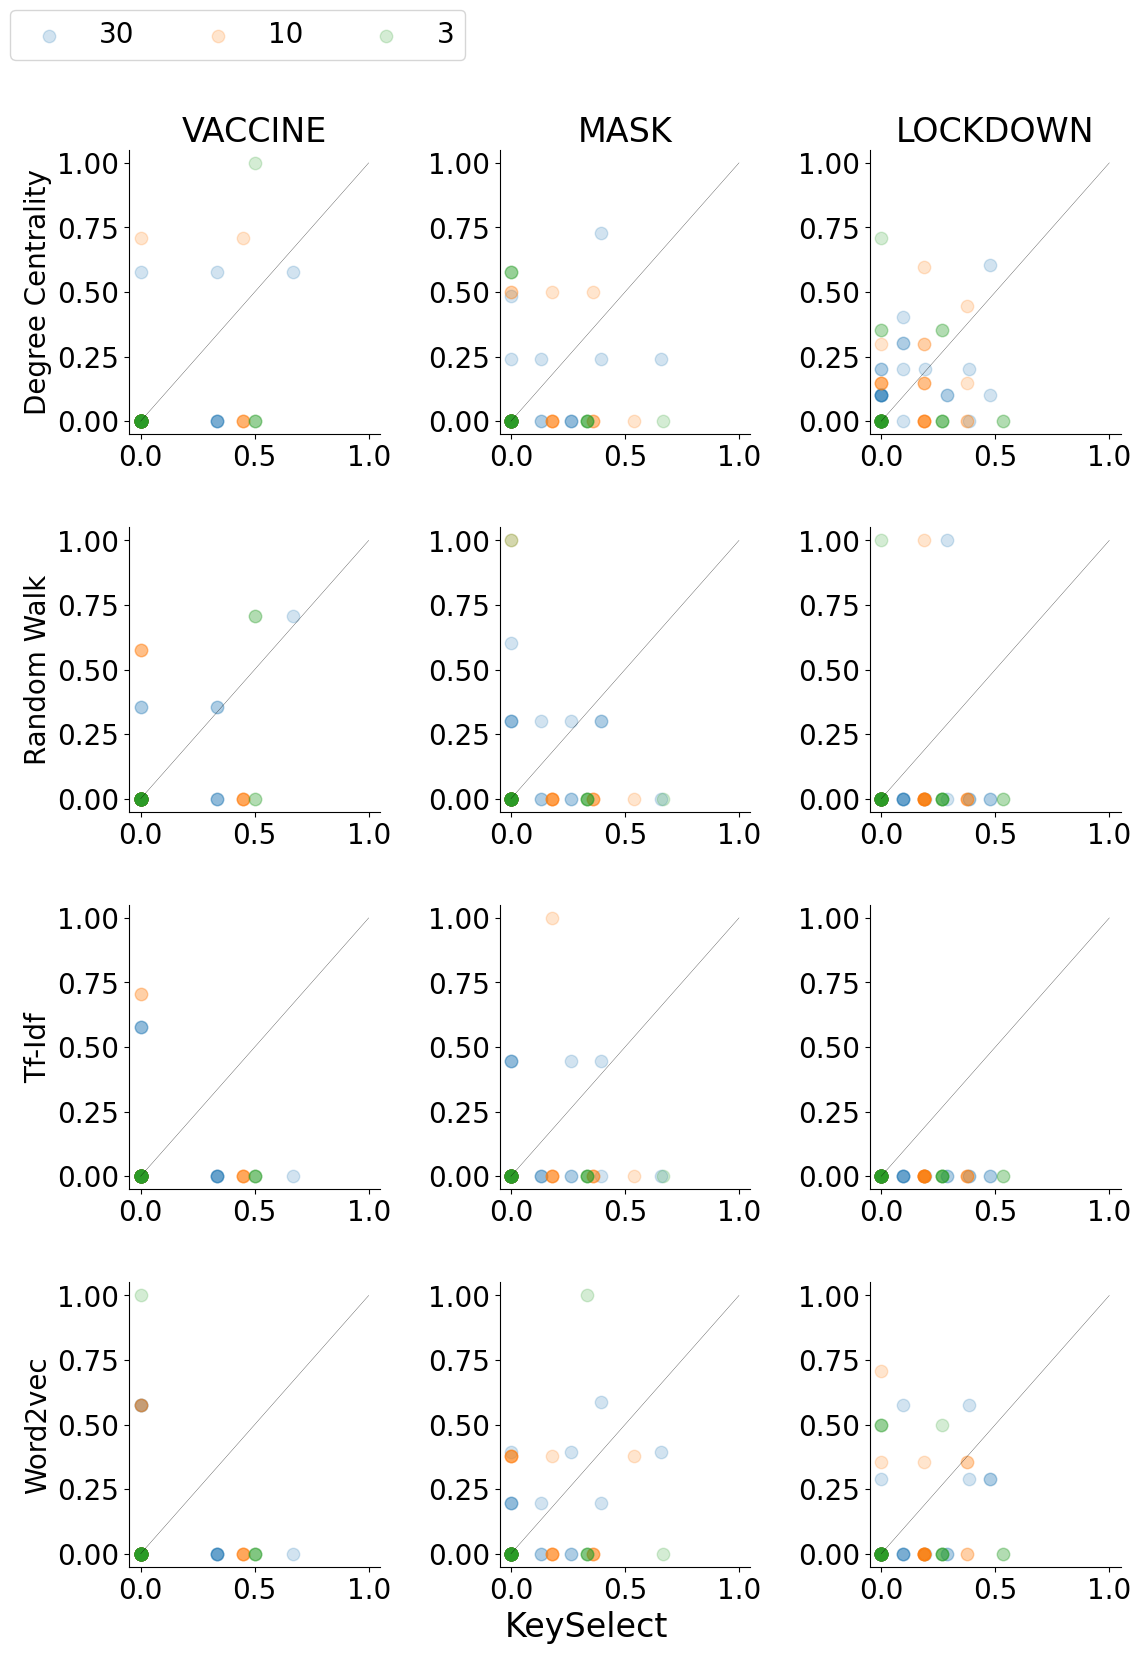

<IPython.core.display.Javascript object>

In [561]:
get_pairwise_budget_figure("precision")

## Tweet Volume

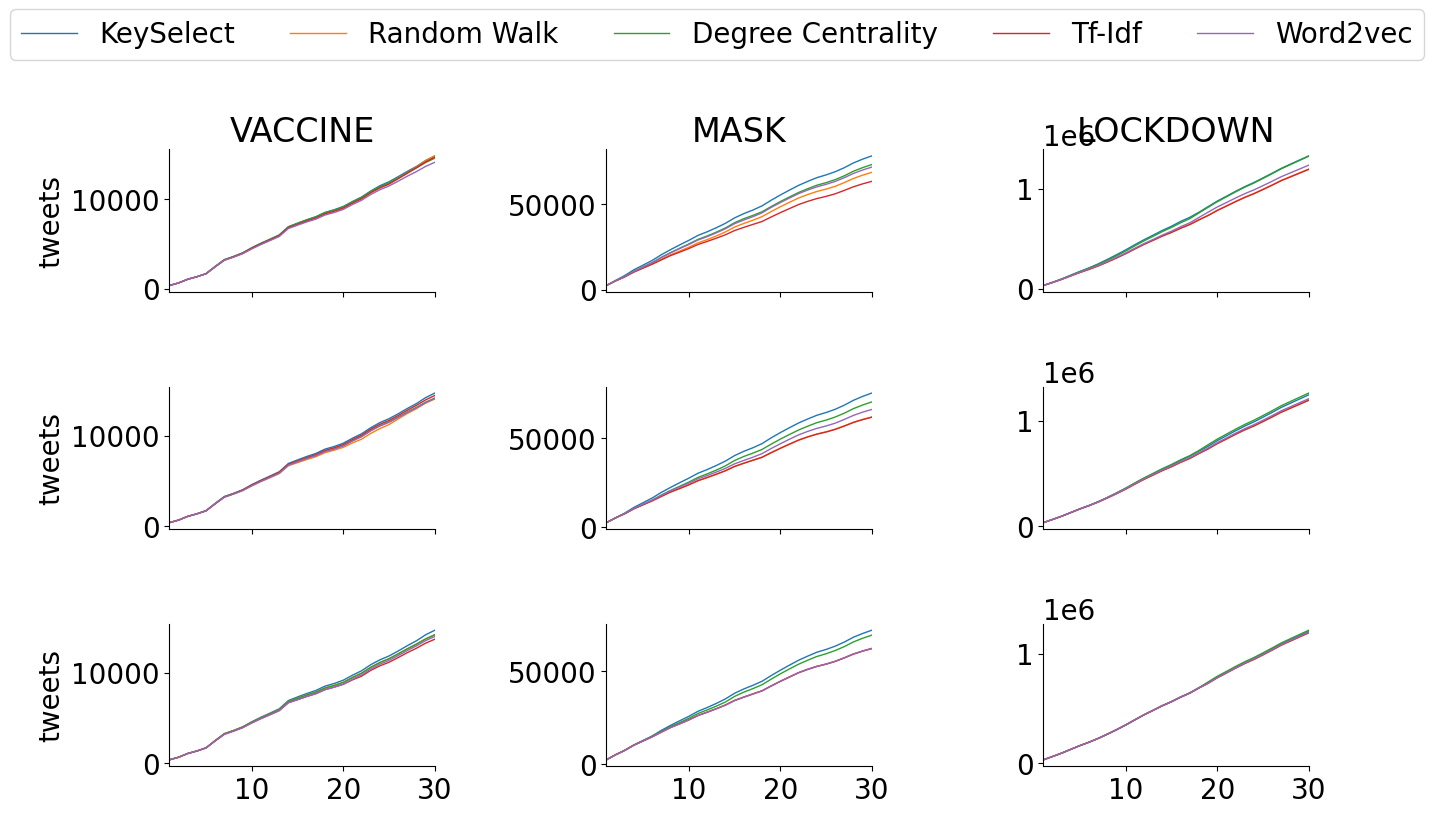

<IPython.core.display.Javascript object>

In [536]:
get_temporal_figure("tweets")

Max gain across settings between Keyselect, and degree: 1.0707752520597287
Max gain across settings between Keyselect, and random: 1.2178442978565553
Max gain across settings between Keyselect, and tfidf: 1.2350694444444446
Max gain across settings between Keyselect, and word2vec: 1.1571283276560709
Average performance ratio between other methods and ours: 1.0400296285842576


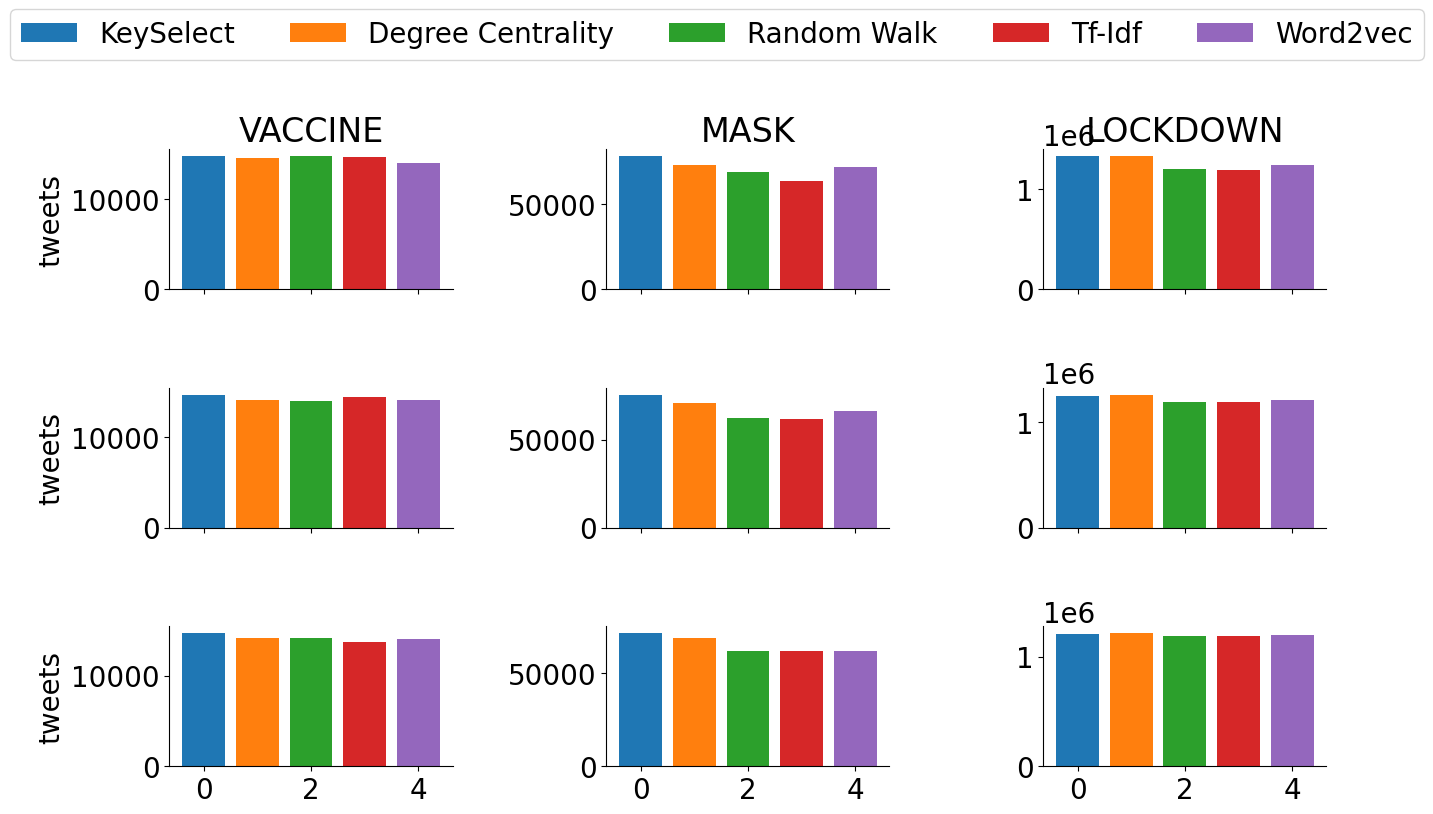

<IPython.core.display.Javascript object>

In [537]:
get_top_bar_plot("tweets")

## Tweet Coverage

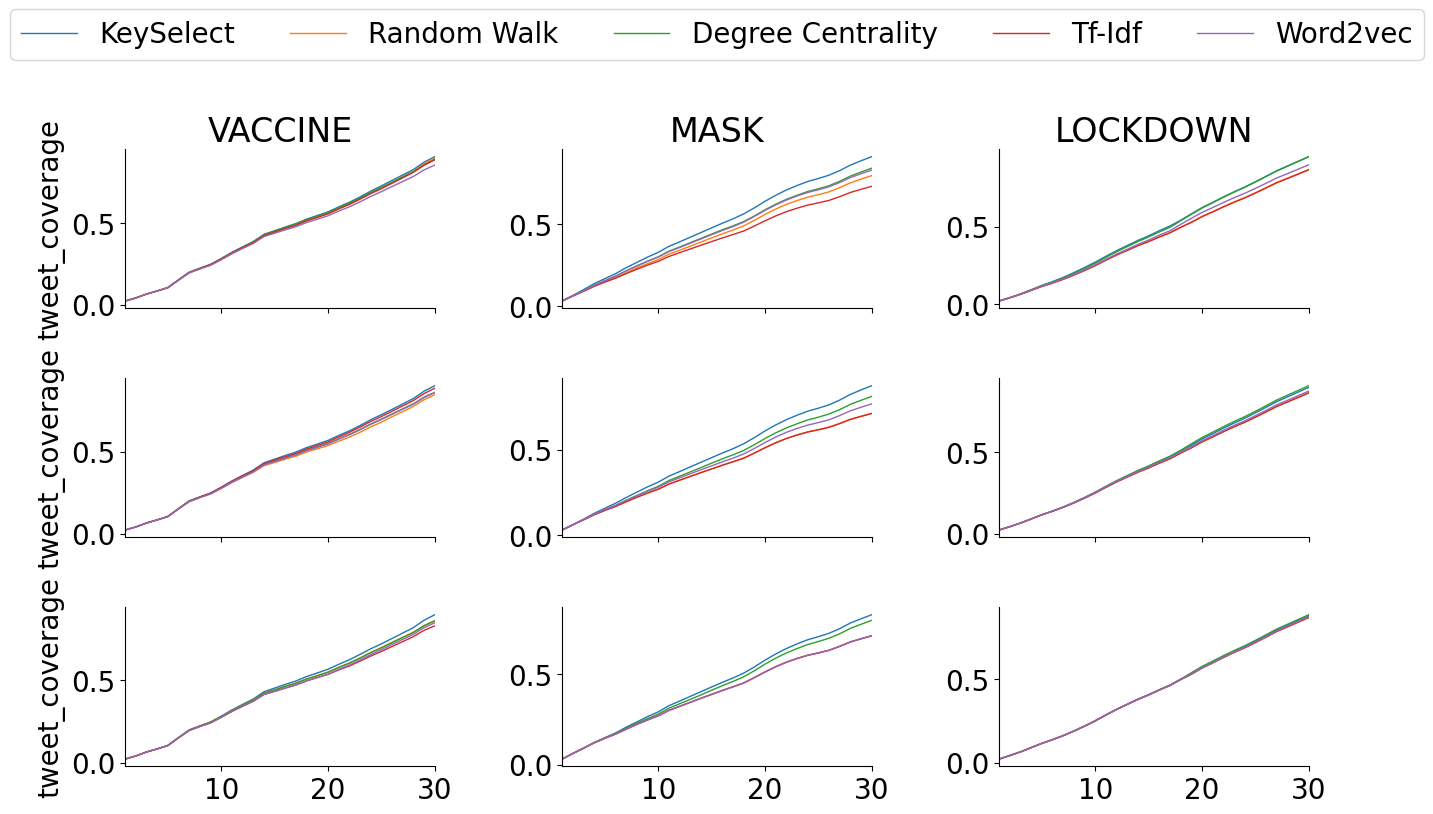

<IPython.core.display.Javascript object>

In [545]:
get_temporal_figure("tweet_coverage")

VACCINE 30 ours 0.9104302477183833
VACCINE 30 degree 0.8932203389830509
VACCINE 30 random 0.9010430247718383
VACCINE 30 tfidf 0.8910039113428944
VACCINE 30 word2vec 0.8586701434159061
VACCINE 10 ours 0.9010430247718383
VACCINE 10 degree 0.8607561929595828
VACCINE 10 random 0.8453715775749674
VACCINE 10 tfidf 0.885658409387223
VACCINE 10 word2vec 0.8586701434159061
VACCINE 3 ours 0.8986962190352021
VACCINE 3 degree 0.8607561929595828
VACCINE 3 random 0.8628422425032595
VACCINE 3 tfidf 0.8311603650586702
VACCINE 3 word2vec 0.8495436766623208
MASK 30 ours 0.9162399576233777
MASK 30 degree 0.8455681115917719
MASK 30 random 0.7999028869073894
MASK 30 tfidf 0.7338439127747859
MASK 30 word2vec 0.8338703981636797
MASK 10 ours 0.8738633353933081
MASK 10 degree 0.8115123157058356
MASK 10 random 0.7119934669374062
MASK 10 tfidf 0.7108899090668315
MASK 10 word2vec 0.7673258585680233
MASK 3 ours 0.8271828374679968
MASK 3 degree 0.7961728613048469
MASK 3 random 0.710779553279774
MASK 3 tfidf 0.71066

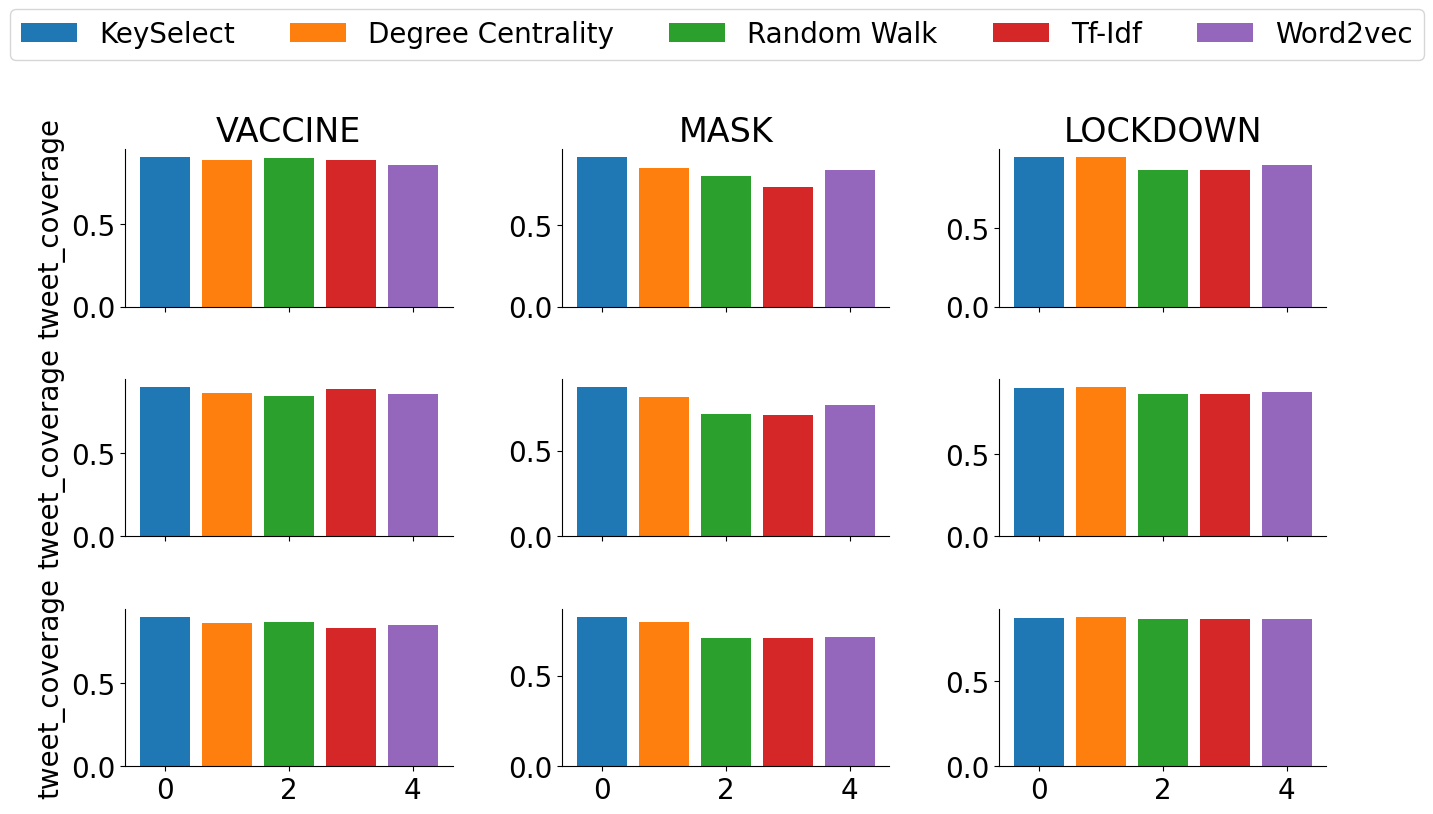

<IPython.core.display.Javascript object>

In [550]:
get_top_bar_plot("tweet_coverage")

## User Volume

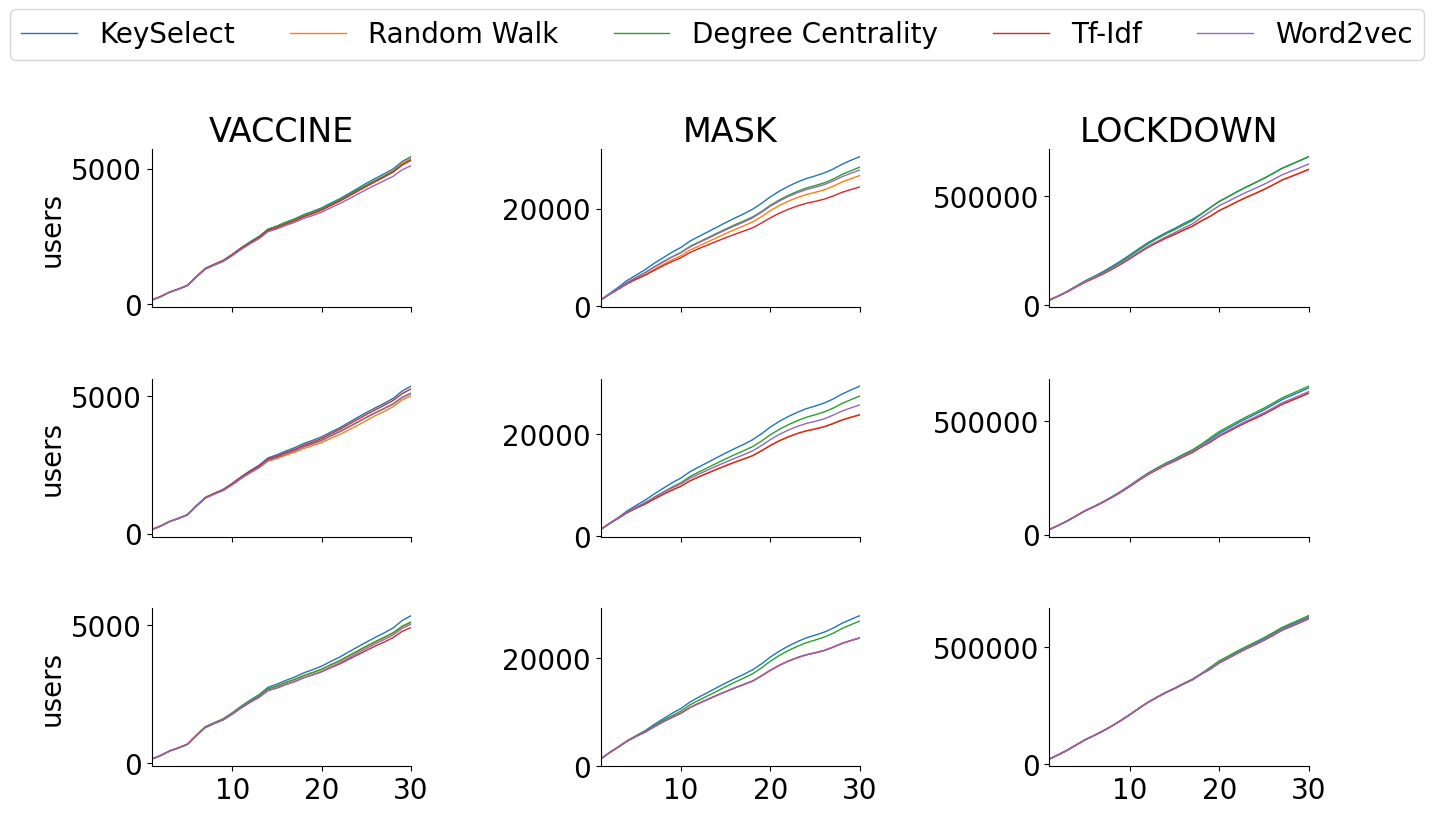

<IPython.core.display.Javascript object>

In [540]:
get_temporal_figure("users")

Max gain across settings between Keyselect, and degree: 1.0755940281769119
Max gain across settings between Keyselect, and random: 1.2351185471666386
Max gain across settings between Keyselect, and tfidf: 1.2538709809208646
Max gain across settings between Keyselect, and word2vec: 1.1730259559968028
Average performance ratio between other methods and ours: 1.0332924501309453


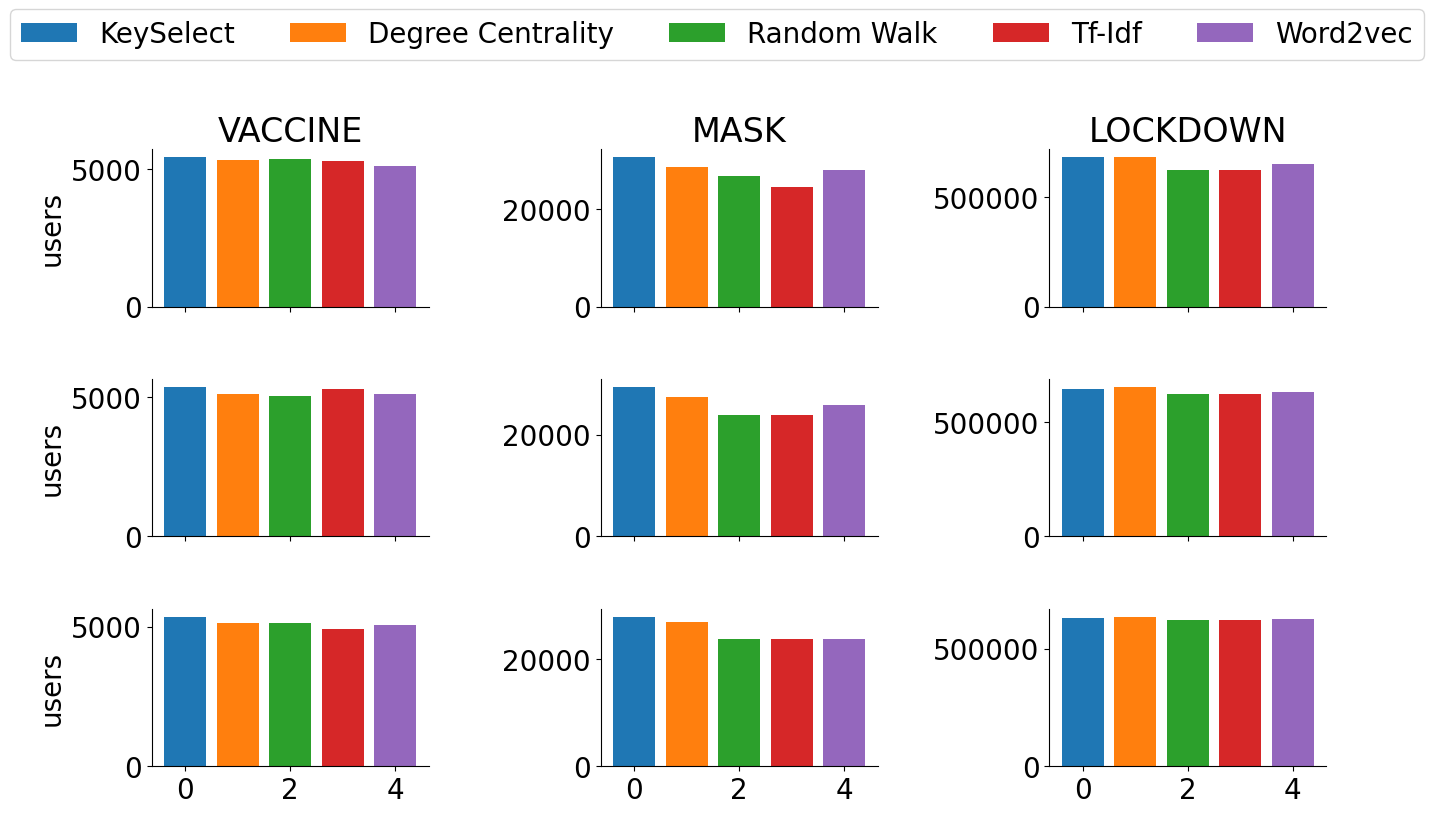

<IPython.core.display.Javascript object>

In [541]:
get_top_bar_plot("users")

## User Coverage

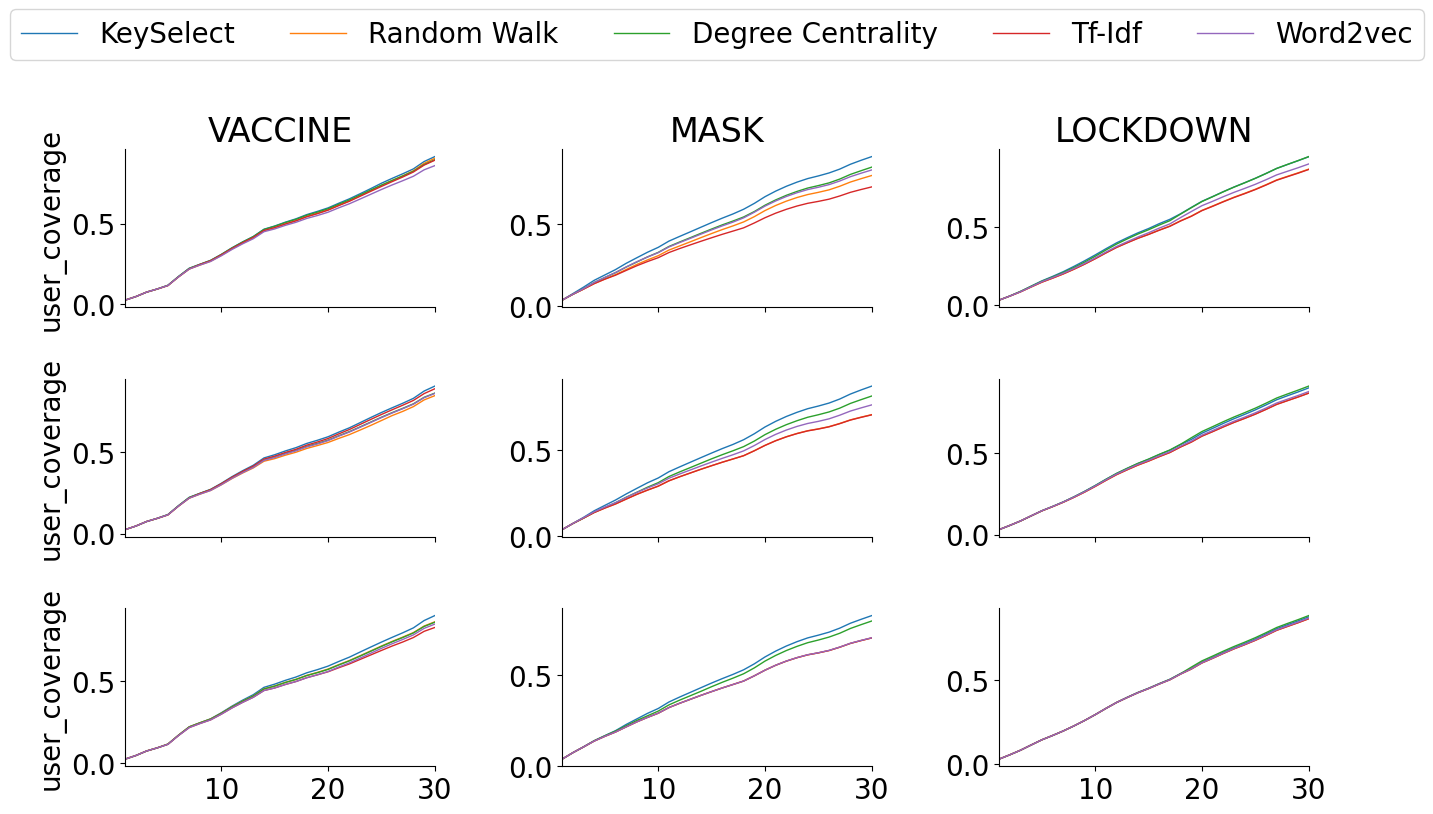

<IPython.core.display.Javascript object>

In [542]:
get_temporal_figure("user_coverage")

VACCINE 30 ours 0.9150260811038197
VACCINE 30 degree 0.8951707891637221
VACCINE 30 random 0.9044253743900387
VACCINE 30 tfidf 0.8924785461887935
VACCINE 30 word2vec 0.8589937741881205
VACCINE 10 ours 0.9039205788322396
VACCINE 10 degree 0.8610129564193169
VACCINE 10 random 0.845364294127545
VACCINE 10 tfidf 0.8874305906108026
VACCINE 10 word2vec 0.8589937741881205
VACCINE 3 ours 0.9015648662291772
VACCINE 3 degree 0.8610129564193169
VACCINE 3 random 0.8635369342083123
VACCINE 3 tfidf 0.828874305906108
VACCINE 3 word2vec 0.8495709237758707
MASK 30 ours 0.9148384404435436
MASK 30 degree 0.8505425062596876
MASK 30 random 0.7993621080243234
MASK 30 tfidf 0.7296113032073447
MASK 30 word2vec 0.8332836532729224
MASK 10 ours 0.8757899129605342
MASK 10 degree 0.8178132824609514
MASK 10 random 0.7090735662334565
MASK 10 tfidf 0.7078812447835937
MASK 10 word2vec 0.7660367235006558
MASK 3 ours 0.8311672826994158
MASK 3 degree 0.8012400143078574
MASK 3 random 0.7077023965661142
MASK 3 tfidf 0.70764

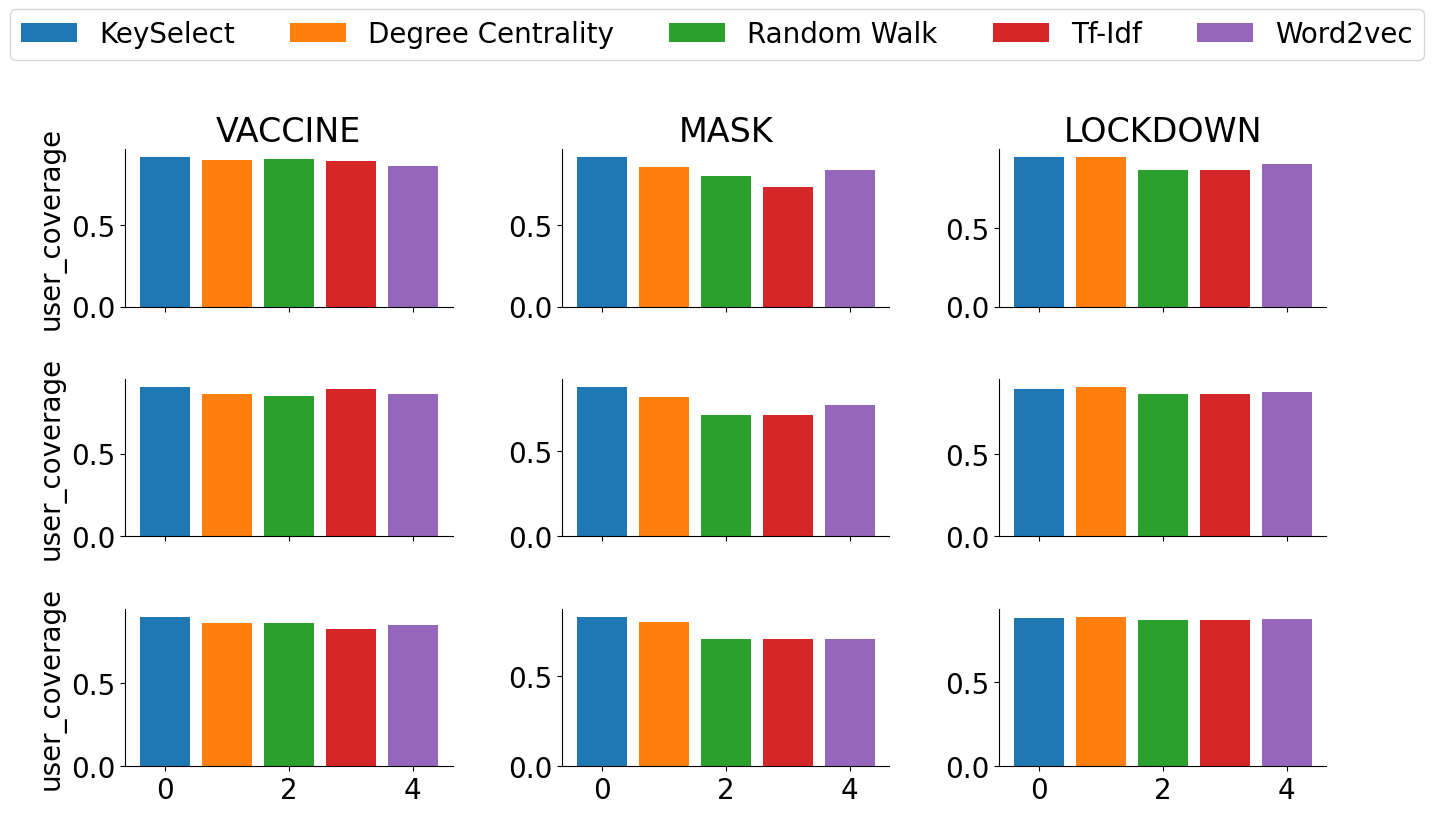

<IPython.core.display.Javascript object>

In [551]:
get_top_bar_plot("user_coverage")

## Dataset Overlap
Code to generate figure 1. Note that complete tweets are not provided, as Twitter forbids sharing information retrieved through its APIs. The tweet ids are provided in a separate file. Here, the hashtags are attached to a re-indexed tweet id.

In [ ]:
all_tweet_ids_file = "figure1_small_subsample_tweet_ids.json"
hydrating_tids_dict = {
    "geocov": {"filepath": "geocov_tids.json"},
    "panacea": {
        "filepath": "panacea_tids.json"
    },
    "echen": {"filepath": "echen_tids.json"},
}

In [ ]:
for dataset in hydrating_tids_dict:
    missing_tids, retrieved_tids = set(), set()
    with open(hydrating_tids_dict[dataset]["filepath"], "r") as f:
        for doc in json.load(f):
            if doc["status"] == 2:
                retrieved_tids.add(doc["tid"])
            elif doc["status"] == -1:
                missing_tids.add(doc["tid"])

    hydrating_tids_dict[dataset]["missing_tids"] = missing_tids
    hydrating_tids_dict[dataset]["retrieved_tids"] = retrieved_tids

In [ ]:
panacea_hashtag_relations_filepath = (
    "panacea_hashtag_relations.json"
)
with open(panacea_hashtag_relations_filepath, "r") as f:
    panacea_hashtag_relations = json.load(f)

In [ ]:
geocov_hashtag_relations_filepath = (
    "geocov_hashtag_relations.json"
)
with open(geocov_hashtag_relations_filepath, "r") as f:
    geocov_hashtag_relations = json.load(f)

In [ ]:
echen_hashtag_relations_filepath = (
    "echen_hashtag_relations.json"
)
with open(echen_hashtag_relations_filepath, "r") as f:
    echen_hashtag_relations = json.load(f)

In [ ]:
def find_3keywords_for_tweets(tid_sequences):
    top_keywords = list()

    hrs = {
        "panacea": panacea_hashtag_relations,
        "echen": echen_hashtag_relations,
        "geocov": geocov_hashtag_relations,
    }

    for tids, datasets in tqdm(tid_sequences):
        seen_tids = set()
        tmp_top_keywords = dict()
        for dataset in datasets:
            for hr in hrs[dataset]:
                hashtag = hr["hashtag"].lower().replace("ー", "-")
                if hr["tid"] in tids and (hr["tid"], hashtag) not in seen_tids:
                    seen_tids.add((hr["tid"], hashtag))
                    if hashtag not in tmp_top_keywords:
                        tmp_top_keywords[hashtag] = 0
                    tmp_top_keywords[hashtag] += 1

        tmp_top_keywords = {
            k: v for k, v in sorted(tmp_top_keywords.items(), key=lambda item: item[1])
        }
        top_keywords.append(list(tmp_top_keywords)[-10:])

    return top_keywords

In [ ]:
def get_sets_sizes():
    """Return 6 set sizes for the Venn diagrams. Look at the retrieved tweet ids."""

    geocov_set = set(hydrating_tids_dict["geocov"]["retrieved_tids"])
    panacea_set = set(hydrating_tids_dict["panacea"]["retrieved_tids"])
    echen_set = set(hydrating_tids_dict["echen"]["retrieved_tids"])

    middle = geocov_set.intersection(echen_set).intersection(panacea_set)

    geocov_echen = geocov_set.intersection(echen_set) - middle
    geocov_panacea = geocov_set.intersection(panacea_set) - middle
    just_geocov = geocov_set - panacea_set - echen_set
    just_panacea = panacea_set - geocov_set - echen_set
    just_echen = echen_set - geocov_set - panacea_set
    panacea_echen = panacea_set.intersection(echen_set) - middle

    # find keywords associated to these sets
    keywords = find_3keywords_for_tweets(
        [
            (just_echen, ["echen"]),
            (just_panacea, ["panacea"]),
            (panacea_echen, ["panacea", "echen"]),
            (just_geocov, ["geocov"]),
            (geocov_echen, ["echen", "geocov"]),
            (geocov_panacea, ["geocov", "panacea"]),
            (middle, ["echen", "geocov", "panacea"]),
        ]
    )

    # (Abc, aBc, ABc, abC, AbC, aBC, ABC)
    return (
        [
            len(just_echen),
            len(just_panacea),
            len(panacea_echen),
            len(just_geocov),
            len(geocov_echen),
            len(geocov_panacea),
            len(middle),
        ],
        keywords,
    )

In [ ]:
subsets, keywords = get_sets_sizes()

In [ ]:
plt.figure(figsize=(25, 16))
v = venn3(subsets=subsets, set_labels=("Chen et al.", "Banda et al.", "Qazi et al."))
c = venn3_circles(subsets=subsets, linestyle="dashed")

subsets_idxs = ["100", "010", "110", "001", "101", "011", "111"]
color_code = {0: "lime", 1: "limegreen", 2: "forestgreen", 3: "darkgreen"}

for i in range(len(keywords)):
    txt = keywords[i][-4:]
    plt.annotate(
        " \n".join(txt),
        xy=v.get_label_by_id(subsets_idxs[i]).get_position() - np.array([0, 0.025]),
        xytext=(-510, -70 * i),
        ha="center",
        textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.5", fc="gray", alpha=0.1),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color="gray"),
    )

plt.tight_layout()
for file_type in file_types:
    figure_filepath = figure_root_dir.joinpath(f"os_datasets_overlaps_sample.{file_type}")
    plt.savefig(figure_filepath, dpi=300)
    
plt.show()

## Tweet Pairwise Count
Code to generate figure 4.

In [26]:
def get_volume_arrays(target_topic, baseline):
    baseline_volumes_dict, our_volumes_dict, budgets = {}, {}, []
    for runtime in runtimes:
        day, topic, _, method, budget =  runtime.split("-")
        
        # retrieve volume if matches baseline
        if target_topic == topic and method == baseline:
            if budget not in baseline_volumes_dict:
                baseline_volumes_dict[budget] = []
            baseline_volumes_dict[budget].append(runtimes[runtime]["tweet_count"])
            
        # retrieve volume if our method
        if target_topic == topic and method == "ours":
            if budget not in our_volumes_dict:
                our_volumes_dict[budget] = []
            our_volumes_dict[budget].append(runtimes[runtime]["tweet_count"])
    
    baseline_volumes, our_volumes = [], []
    for budget in baseline_volumes_dict:
        budgets.append(budget)
        #baseline_volumes.append(normalize(np.array(baseline_volumes_dict[budget]).reshape(1, -1)))
        #our_volumes.append(normalize(np.array(our_volumes_dict[budget]).reshape(1, -1)))
        baseline_volumes.append(baseline_volumes_dict[budget])
        our_volumes.append(our_volumes_dict[budget])
    
    return budgets, our_volumes, baseline_volumes


<IPython.core.display.Javascript object>

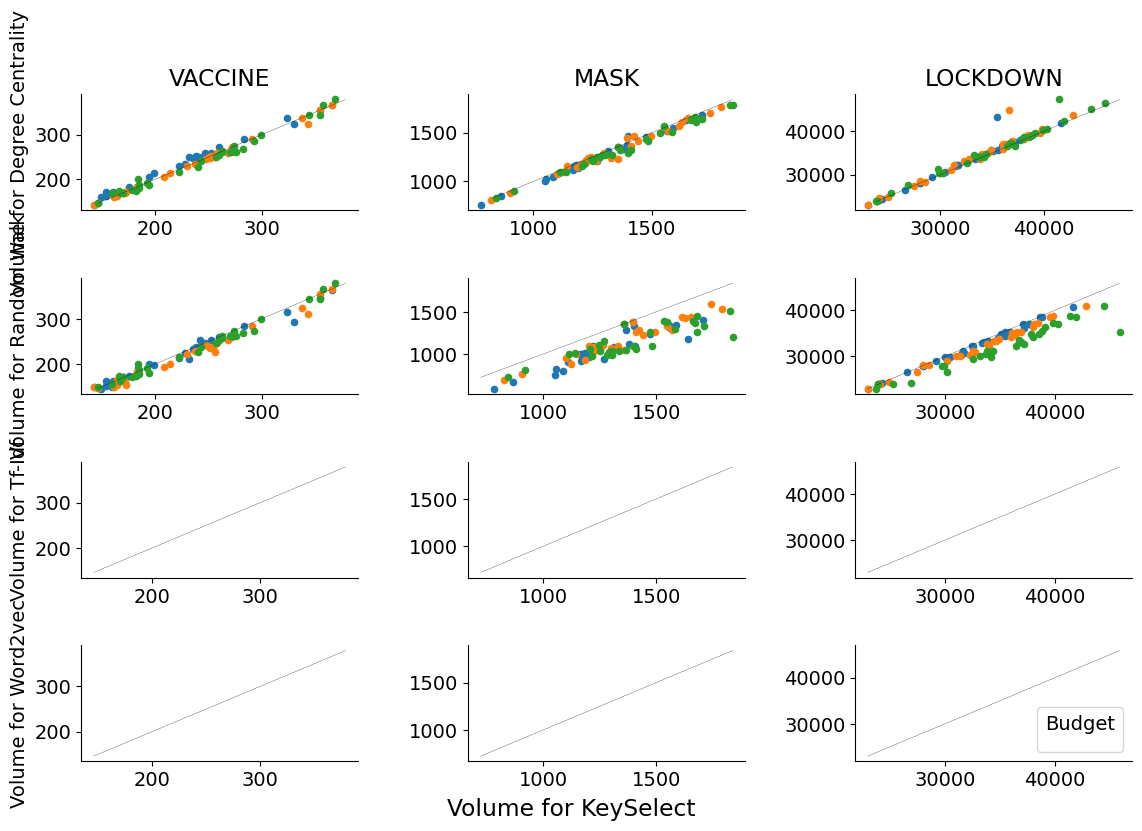

<IPython.core.display.Javascript object>

In [27]:
fig, axs = plt.subplots(len(other_methods), len(topics), figsize=(12, 8))
for topic_idx, topic in enumerate(topics):
    for method_idx, method in enumerate(other_methods):
        budgets, our_volumes, baseline_volumes = get_volume_arrays(topic, method)
        for budget, our_volume, baseline_volume in zip(
            budgets, our_volumes, baseline_volumes
        ):
            axs[method_idx, topic_idx].scatter(
                our_volume, baseline_volume, label=budget, s=20
            )

        axs[method_idx, topic_idx].plot(
            [
                min(np.amin(our_volume), np.amin(baseline_volume)),
                max(np.amax(our_volume), np.amax(baseline_volume)),
            ],
            [
                min(np.amin(our_volume), np.amin(baseline_volume)),
                max(np.amax(our_volume), np.amax(baseline_volume)),
            ],
            color="black",
            linewidth=0.2,
        )

        if method_idx == 0:
            axs[method_idx, topic_idx].set_title(f"{topic}")
        if topic_idx == 0:
            axs[method_idx, topic_idx].set_ylabel(f"Volume for {method_map[method]}")
        axs[method_idx, topic_idx].spines["top"].set_visible(False)
        axs[method_idx, topic_idx].spines["right"].set_visible(False)


fig.tight_layout(pad=2.0)
fig.supxlabel("Volume for KeySelect")
plt.legend(loc="lower right", title="Budget")
plt.savefig("relative_volume.png", dpi=300)
plt.show()